This notebook compares the results of genome-wide boundary CTCF perturbations with DNA shape.

First, in silico perturbation results are loaded from h5 and filtered based on whether a given boundary was responsive to CTCF motif permutation.

Sites are further filtered to have similar jaspar CTCF scores for the core motif.

Sequences around each site are loaded and converted to DNA shape.

The propeller twist (proT) is somewhat different between motifs that have strong & weak effects on SCD/insulation, but not as dramatically as when no restriction is placed on the core motif Jaspar score. However, this likely just reflects different GC content ~10bp upstream of strong motifs.


In [1]:
import matplotlib.pyplot as plt
import bioframe 
import pandas as pd
import numpy as np 
import h5py
import os
from scipy.stats import spearmanr, pearsonr

import pysam

from matplotlib import colors
cmap_purple_green_GC = colors.ListedColormap([ 
    'mistyrose', #a 
    'darkseagreen', #c
    'plum', #g
    'beige' #t
])
cmap_rhee = colors.ListedColormap([
    'red', #a red
    'blue', #c blue
    'yellow', #g yllow
    'green' #t green
])

cmaps = [cmap_purple_green_GC, cmap_rhee]


In [2]:
import akita_utils
from akita_utils.utils import h5_to_df, filter_by_chrmlen, dna_1hot, dna_1hot_index, dna_1hot_GC, dna_rc

### Load & filter genomic deletion SCD for boundary CTCFs

In [3]:
df = akita_utils.filter_boundary_ctcfs_from_h5(
    h5_dirs="/project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model*/scd.h5",
    score_key="SCD",
    threshold_all_ctcf=5,
)

annotating each site with boundary-wide scores


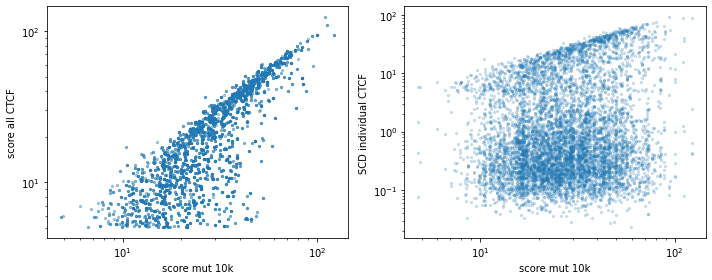

In [4]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.scatter(df['score_10k'],df['score_all_ctcf'], 5, alpha=0.2)
plt.loglog()
plt.xlabel('score mut 10k')
plt.ylabel('score all CTCF')

plt.subplot(122)
plt.scatter(df['score_10k'],df['SCD'], 5, alpha=0.2)
plt.loglog()
plt.xlabel('score mut 10k')
plt.ylabel('SCD individual CTCF')
plt.tight_layout()

In [5]:
# filter by rmsk
sites = akita_utils.filter_by_rmsk(df) 

## add scores for jaspar core motif to table of sites
ctcf_motifs = bioframe.read_table('/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz',
                                  schema="jaspar", skiprows=1)
sites = sites.merge(ctcf_motifs, how='left', 
                    left_on= ['chrom','start_2','end_2'], right_on=['chrom','start','end'])

sites_unfiltered = sites.copy()

filtering sites by overlap with rmsk


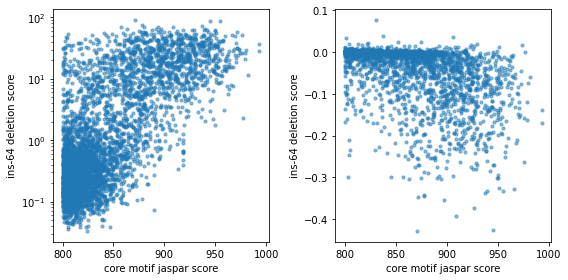

In [6]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter( sites['score'], sites['SCD'], 10, alpha=0.5)
plt.semilogy()
plt.xlabel('core motif jaspar score')
plt.ylabel('ins-64 deletion score')

plt.subplot(122)
plt.scatter( sites['score'], sites['INS-64'], 10, alpha=0.5)
plt.xlabel('core motif jaspar score')
plt.ylabel('ins-64 deletion score')

plt.tight_layout()

In [7]:
## get sites with similar core motif strengths 
#sites = sites.query('(score > 800) and (score < 850)')

sites = sites_unfiltered.query('(score > 850) and (score < 875)').copy()
sites.reset_index(drop=True, inplace=True)

In [8]:
## split sites by strong vs weak, here using insulation score (ins-64)
num_sites = 100
sites_weak = sites['INS-64'].values > -.01
sites_strong = sites['INS-64'].values < -.03

sites_weak = np.where(sites_weak)[0]
sites_strong = np.where(sites_strong)[0]
print('num weak',len(sites_weak), ', num strong',len(sites_strong))

sites_weak = sites_weak[np.sort(
    np.random.choice(len(sites_weak),num_sites,replace=False)
)]
sites_strong = sites_strong[np.sort(
    np.random.choice(len(sites_strong),num_sites,replace=False)
)]
sites_strong = sites.loc[sites_strong].reset_index(drop=True)
sites_weak = sites.loc[sites_weak].reset_index(drop=True)


num weak 261 , num strong 155


In [9]:
def get_seqs(sites, genome_file='/project/fudenber_735/genomes/mm10/mm10.fa', extent_bp=100, verbose=False):
    """
    Get and orient DNA sequence around motifs, and return arrays with various transformation:
    into 1hot, index, and binary (GC). 
    """
    genome_open = pysam.Fastafile(genome_file)

    seqs=[]
    seqs_1hot = []
    seqs_index=[]
    seqs_GC =[]
    for i in range(len(sites)):
        if verbose: 
            if np.mod(i, 50)==0: print(i)
        chrm, start, end, strand = sites.loc[i][['chrom','start_2','end_2','strand_2']]
        start = start-extent_bp
        end = end+extent_bp
        seq =  genome_open.fetch(chrm, start, end).upper()
        if strand == '-':
            seq = dna_rc(seq)
        seqs.append(seq)
        seqs_1hot.append(dna_1hot(seq))
        seqs_index.append( dna_1hot_index(seq))
        seqs_GC.append( dna_1hot_GC(seq))
    seqs_index = np.array(seqs_index)
    seqs_GC = np.array(seqs_GC)
    seqs_1hot  = np.array(seqs_1hot)
    return seqs, seqs_1hot, seqs_index, seqs_GC


In [10]:
seqs_weak, seqs_1hot_weak, seqs_index_weak, seqs_GC_weak = get_seqs(sites_weak, 
                                                                    genome_file='/project/fudenber_735/genomes/mm10/mm10.fa', 
                                                                    extent_bp=100)
seqs_strong, seqs_1hot_strong, seqs_index_strong, seqs_GC_strong = get_seqs(sites_strong, genome_file='/project/fudenber_735/genomes/mm10/mm10.fa', extent_bp=100)

In [11]:
#### load in Rohs lab DNA shape table
dnashape = pd.read_excel('/project/fudenber_735/motifs/DNA shape query table.xlsx', skipfooter=4)
dnashape_dict = dnashape.set_index('Pentamer')#.loc['AAAAAA']
dnashape_rc = dnashape.copy()
for i in range(len(dnashape)):
    dnashape_rc.loc[i,'Pentamer'] =    dna_rc(  dnashape_rc.loc[i,'Pentamer'] )
dnashape_dict = pd.concat([dnashape, dnashape_rc])
dnashape_dict = dnashape_dict.set_index('Pentamer')


In [12]:
PENTAMER_LEN = 5

def shape_converter(seq, shape_key='MGW'):
    shape_vec = []
    for i in range(len(seq)-PENTAMER_LEN):
        subseq = seq[i:i+PENTAMER_LEN]
        if 'N' in subseq:
            shape_vec.append(np.nan)
        else:
            shape_vec.append( dnashape_dict[shape_key].loc[subseq] )
    return np.array(shape_vec)

def shape_converter_multi(seq_list, shape_key='MGW'):
    shape_mat = []
    for seq in seq_list:
        shape_mat.append( shape_converter(seq, shape_key))
    return np.array(shape_mat)
    

In [13]:
shape_val_dict = {}
for shape_key in dnashape.keys()[1:]:
    shape_weak = shape_converter_multi(seqs_weak, shape_key= shape_key)
    shape_strong = shape_converter_multi(seqs_strong, shape_key=shape_key)
    shape_val_dict[shape_key] = [shape_weak, shape_strong]
    

In [14]:
shape_corrs = {}
bp_start, bp_stop = 80, 139
inds_no_center= np.hstack((
    np.arange(20), 
    np.arange(39, bp_stop-bp_start) 
))

for shape_key in dnashape.keys()[1:]:
    weak_shape, strong_shape =   shape_val_dict[shape_key]

    shape_corrs[shape_key] = [np.round(
    spearmanr(
        np.nanmean(weak_shape[:,bp_start:bp_stop],axis=0)[inds_no_center],
        np.nanmean(strong_shape[:,bp_start:bp_stop],axis=0)[inds_no_center]
    )[0],2) , 
                             
    np.round(np.sum(np.abs(
        np.nanmean(weak_shape[:,bp_start:bp_stop],axis=0)[inds_no_center]-
        np.nanmean(strong_shape[:,bp_start:bp_stop],axis=0)[inds_no_center]))
             ,2)
           ] 

Text(0, 0.5, 'total diff')

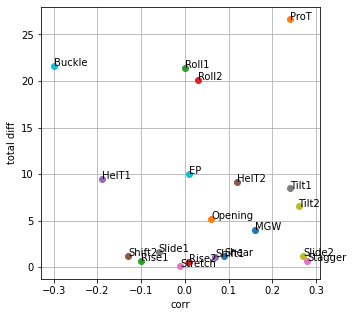

In [15]:
plt.figure(figsize=(5,5))
for k,v in shape_corrs.items():
    plt.plot(v[0],v[1],'o')
    plt.text(v[0],v[1],k)
plt.grid()
plt.xlabel('corr')
plt.ylabel('total diff')

MGW 4.31 5.69


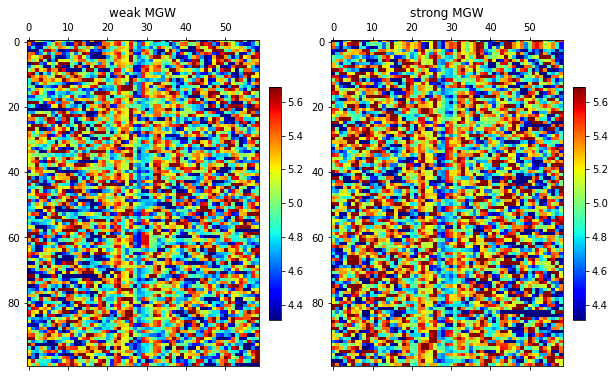

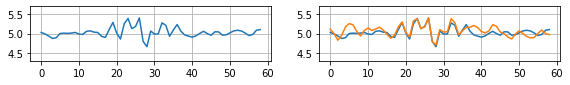

ProT -11.32 -2.13


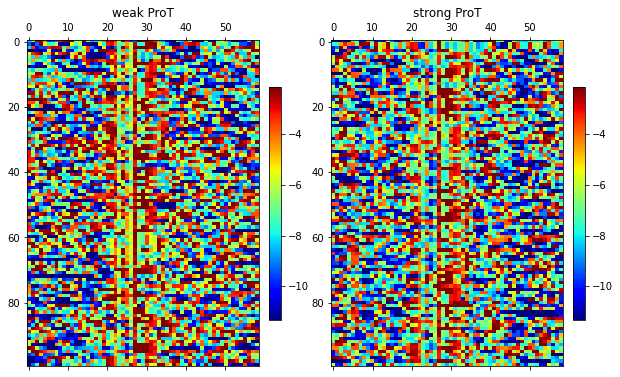

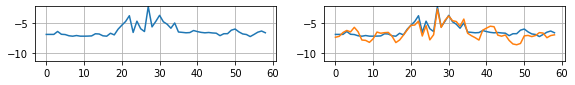

Roll1 -3.96 4.9


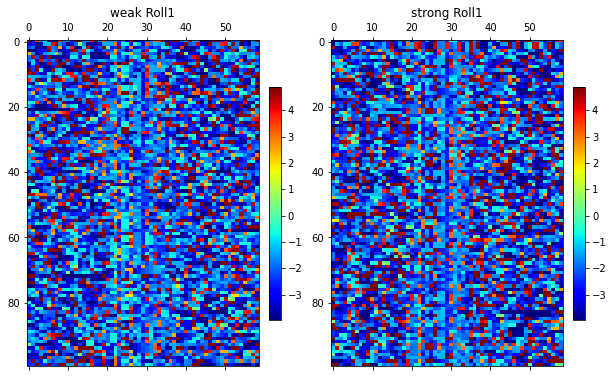

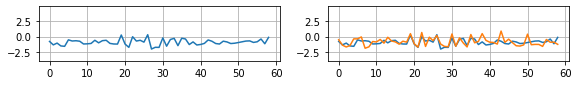

Roll2 -3.98 4.1


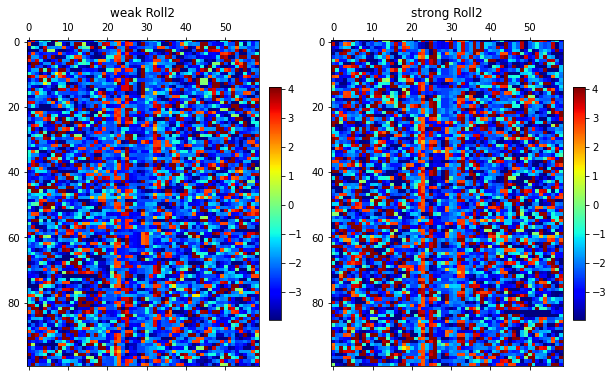

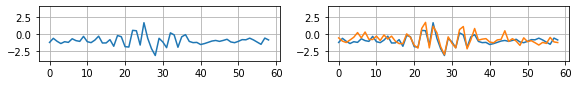

HelT1 31.94 36.59


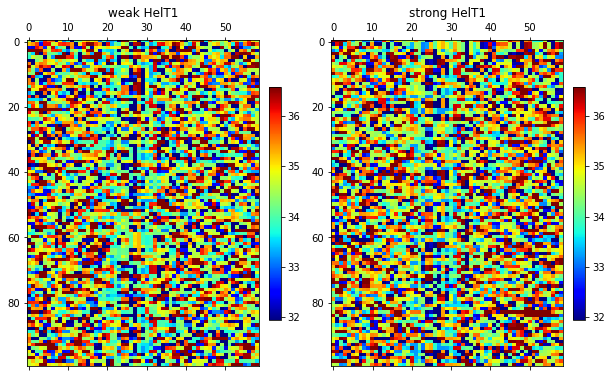

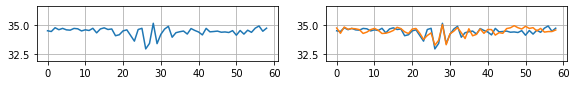

HelT2 31.51 36.26


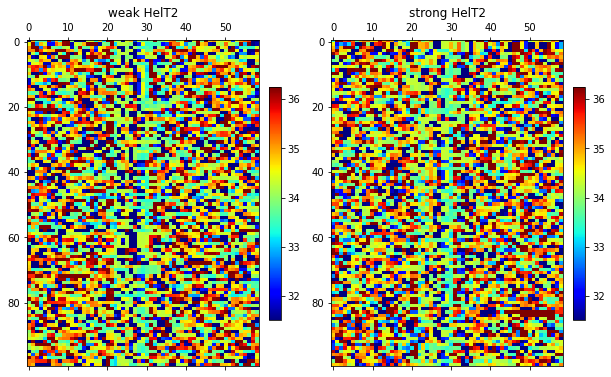

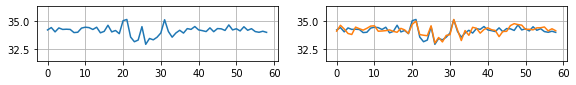

Stretch -0.04 -0.01


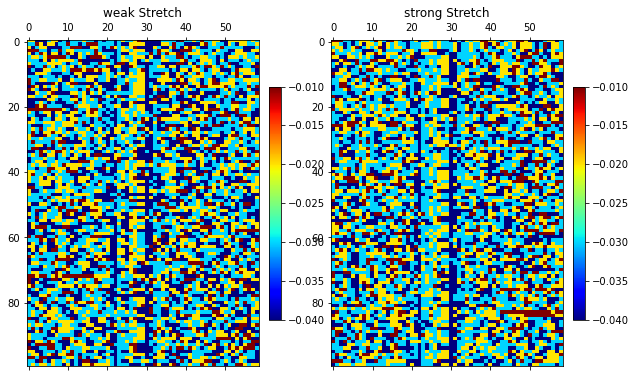

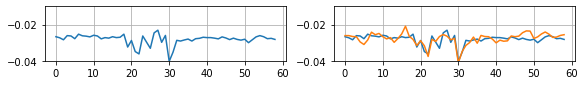

Tilt1 -2.07 1.99


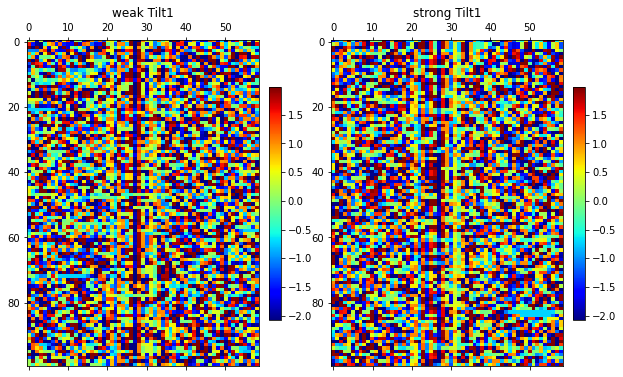

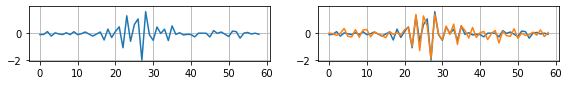

Tilt2 -2.16 2.1


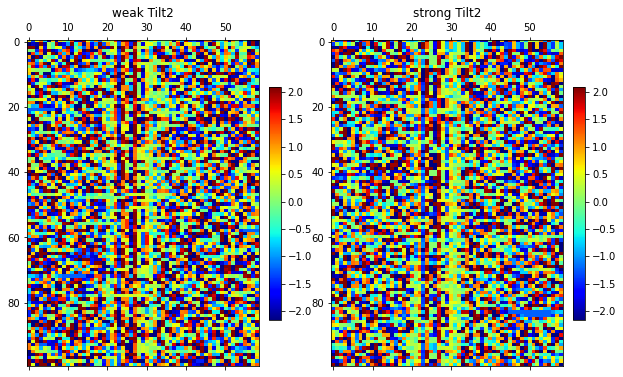

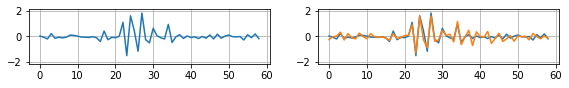

Buckle -3.75 5.89


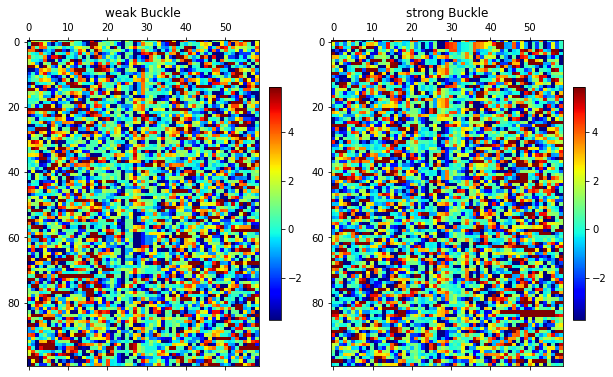

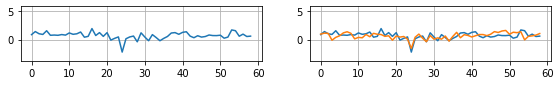

Shear -0.28 0.26


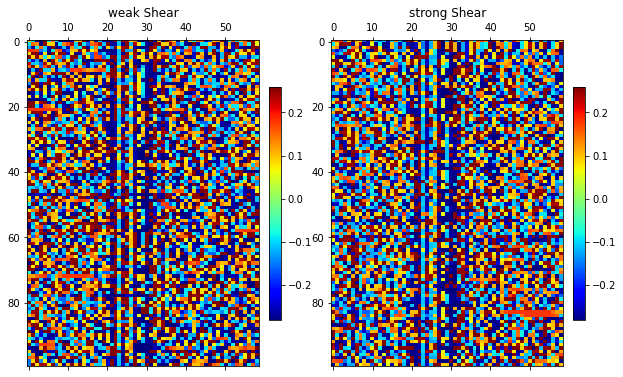

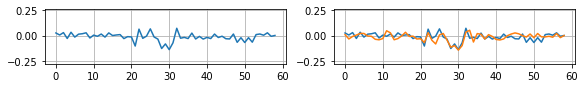

Opening -1.3 0.42


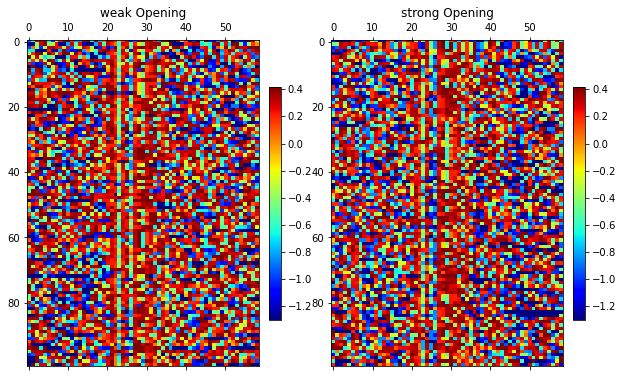

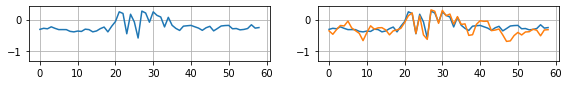

Rise1 3.18 3.49


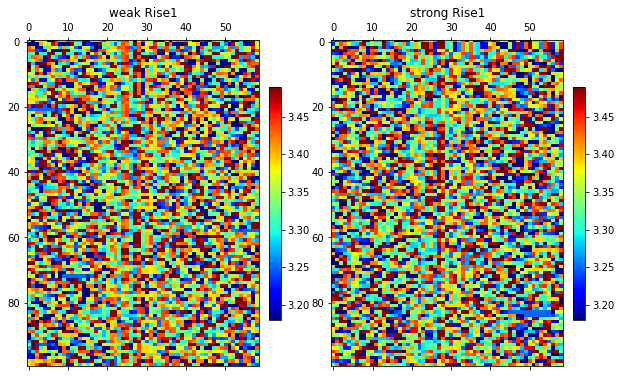

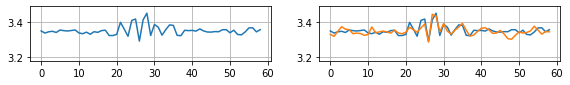

Rise2 3.18 3.47


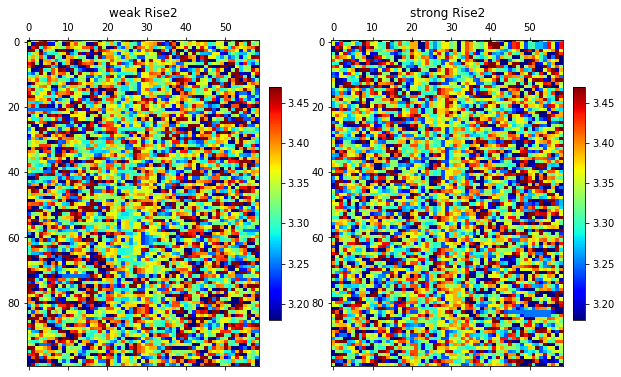

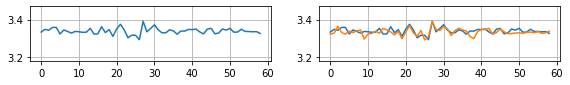

Shift1 -0.27 0.33


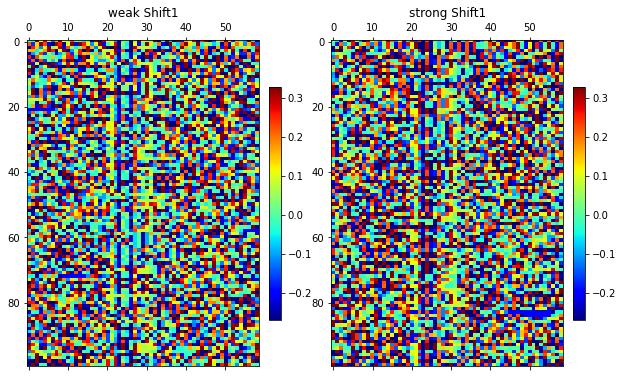

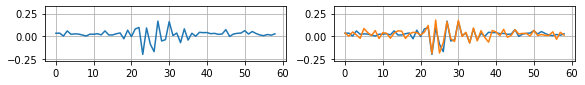

Shift2 -0.27 0.31


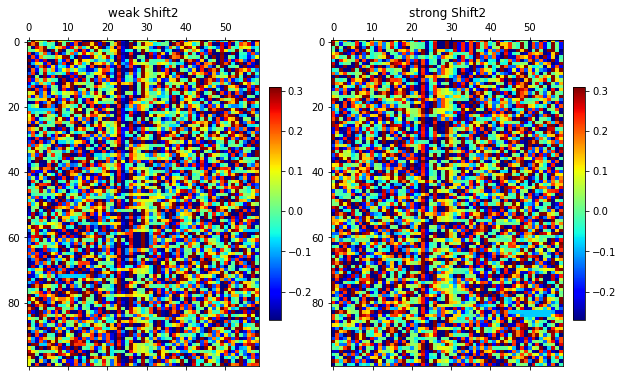

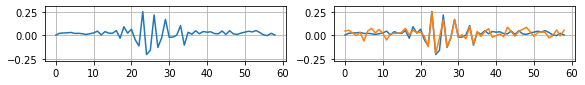

Stagger -0.20999999999999996 0.13


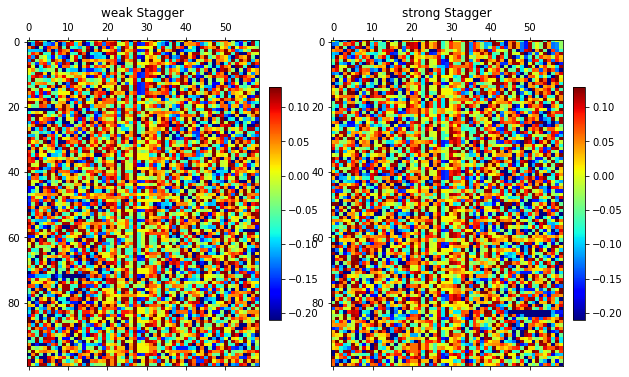

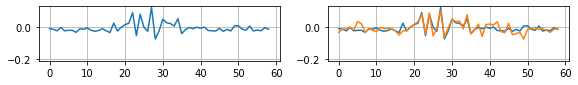

Slide1 -1.8200000000000003 -1.18


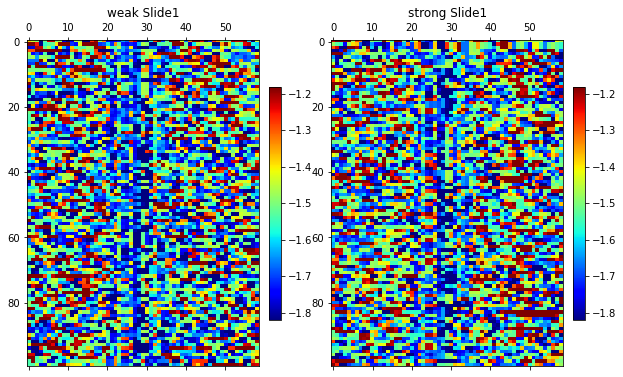

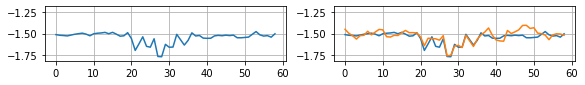

Slide2 -1.8 -1.21


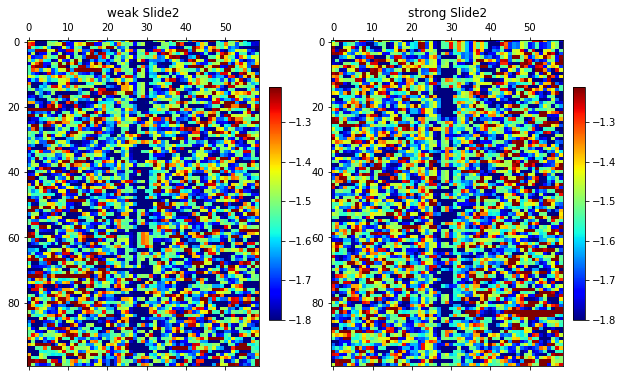

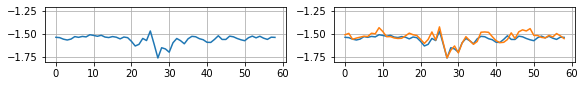

EP -8.27 -5.23


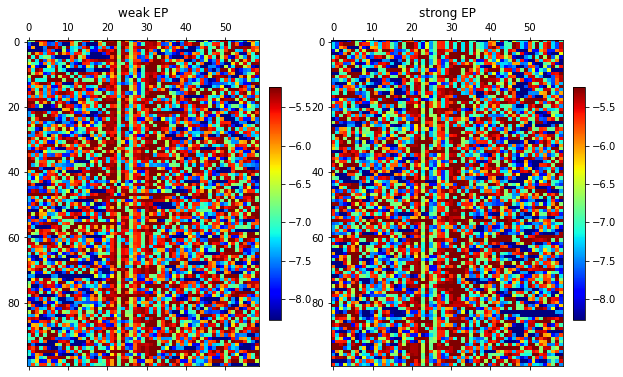

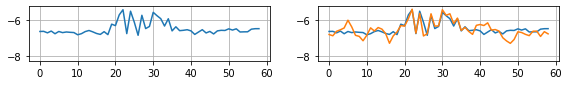

In [16]:
for shape_key in dnashape.keys()[1:]:        
    weak_shape, strong_shape =   shape_val_dict[shape_key]
    
    min_val, max_val = np.nanpercentile(
        #[weak_shape , strong_shape ],[5,95])
        [weak_shape , strong_shape ],[10,90])
    print(shape_key, min_val, max_val)
       
    bp_start,bp_stop = (80, 139)
    
    plt.figure(figsize=(10,6))
    plt.subplot(121)
    im = plt.matshow(
        weak_shape[:,bp_start:bp_stop],  vmin=min_val, vmax=max_val,cmap='jet',
        fignum=False)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('weak '+str(shape_key))
    ax=plt.gca()
    ax.set_aspect('auto')
    
    plt.subplot(122)
    im = plt.matshow(
        strong_shape[:,bp_start:bp_stop],  vmin=min_val, vmax=max_val,cmap='jet',
        fignum=False)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('strong '+str(shape_key))
    #plt.tight_layout()
    ax.set_aspect('auto')
    ax=plt.gca()
    ax.set_aspect('auto')
    plt.show()
    
    plt.figure(figsize=(9.5,1))
    plt.subplot(121)
    plt.plot(np.mean(weak_shape[:,bp_start:bp_stop],axis=0))
    plt.grid()
    plt.ylim([min_val,max_val])
    plt.subplot(122)
    plt.plot(np.mean(weak_shape[:,bp_start:bp_stop],axis=0))

    plt.plot(np.mean(strong_shape[:,bp_start:bp_stop],axis=0),label='strong')
    plt.grid()
    plt.ylim([min_val,max_val])    
    plt.show()
    